## Homework 4 :  Physics 403, S25
Aidan Meador-Woodruff (ameadorw@ur.rochester.edu)

Due: Friday 28 February, 2025

In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import special 
import timeit

### Problem 1 : Computing a Posterior PDF
**

---
*a).*

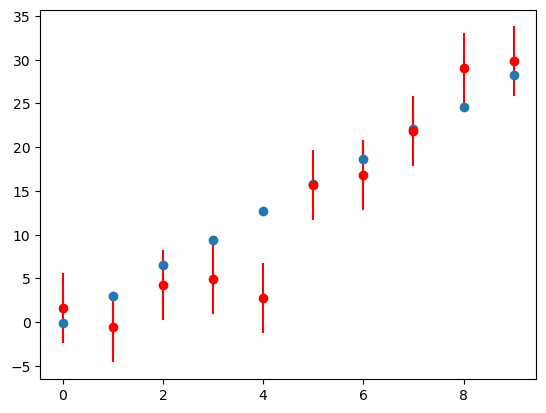

In [70]:
data1 = np.loadtxt("HW4/data1.txt").transpose()
data2 = np.loadtxt("HW4/data2.txt").transpose()
plt.errorbar(data1[0],data1[1],yerr=data1[2], fmt='o');
plt.errorbar(data2[0],data2[1],yerr=data2[2], fmt='o', color='red');


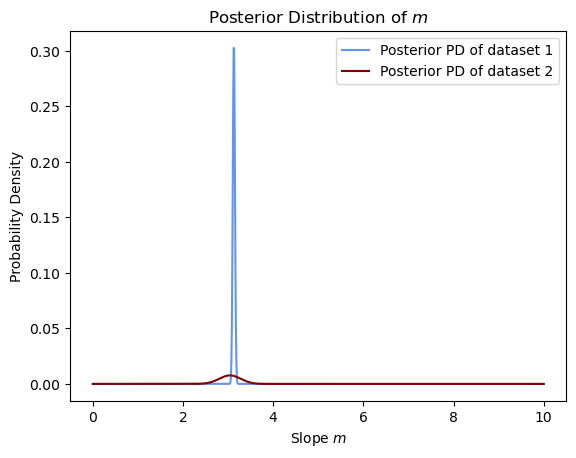

In [ ]:
def compute_posterior(x, y, dy, m_values):
    post = []
    for m in m_values:
        likelihood = np.exp(-0.5 * np.sum(((y - m*x)/dy)**2))
        post.append(likelihood)
    post = np.array(post)
    return post #/ np.trapezoid(post, m_values)  # Normalize

x1, y1, dy1 = data1[0], data1[1], data1[2]
x2, y2, dy2 = data2[0], data2[1], data2[2]
m_values = np.linspace(0, 10, 1000)

posterior1 = compute_posterior(x1, y1, dy1, m_values)
posterior2 = compute_posterior(x2, y2, dy2, m_values)

plt.plot(m_values, posterior1, label='Posterior PD of dataset 1',color='cornflowerblue')
plt.plot(m_values, posterior2, label='Posterior PD of dataset 2', color='maroon')

plt.xlabel(r"Slope $m$")
plt.ylabel("Probability Density")
plt.title(r'Posterior Distribution of $m$')
plt.legend()
plt.show()

Clearly, the first dataset is more precise due to its far narrower Gaussian peak.

In [71]:

def find_mpv_and_credible_intervals(m_values, posterior, ci_levels=[0.68, 0.90]):
    sorted_indices = np.argsort(posterior)[::-1]
    sorted_m = m_values[sorted_indices]
    sorted_post = posterior[sorted_indices]
    cumulative_prob = np.cumsum(sorted_post) / np.sum(sorted_post)
    
    mpv = sorted_m[0]
    ci_ranges = {}
    for level in ci_levels:
        cutoff = np.interp(level, cumulative_prob, sorted_m)
        ci_ranges[level] = (sorted_m[sorted_m >= cutoff].min(), sorted_m[sorted_m <= cutoff].max())
    
    return mpv, ci_ranges


mpv1, ci_ranges1 = find_mpv_and_credible_intervals(m_values, posterior1)
mpv2, ci_ranges2 = find_mpv_and_credible_intervals(m_values, posterior2)

print(f"MPV 1: {mpv1:.2f}")
for level, (low, high) in ci_ranges1.items():
    print(f"{int(level*100)}% CI: ({low:.2f}, {high:.2f})")


print(f"MPV 2: {mpv2:.2f}")
for level, (low, high) in ci_ranges2.items():
    print(f"{int(level*100)}% CI: ({low:.2f}, {high:.2f})")


MPV 1: 3.12
68% CI: (3.11, 3.10)
90% CI: (3.15, 3.14)
MPV 2: 3.04
68% CI: (3.24, 3.23)
90% CI: (2.75, 2.74)


### Problem 2 : Estimator of a Poisson Mean

*We consider a set of measurements* $\mathbf{x} =\left\{x_i\right\}$ *drawn from a Poisson distribution with mean* $\lambda$.

---
*a).* We wish to find the best estimator of $\hat{\lambda}$ of the mean. This is the expectation of $\mathbf{x}$, or
$$\mathbb{E}[\mathbf{x}] = \mathbb{E}\left[\frac{1}{N}\sum_{i} x_i\right] = \mu$$
where we $N$ samples in our set. By linearity, we have that 

$$\mu = \frac{1}{N} \sum_{i} \mathbb{E}[x_i]$$

The expectation of a Poisson random variable is just $\lambda$, so we see that the estimator of the mean is

$$\mu = \frac{1}{N} \sum_i \lambda_i = \lambda$$

*b).*

*c).*

### Problem 3 : Estimators of Gaussian Variance
**

---
*a).*